### A simple demo notebook of applying rank coded training on synthetic data

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.cm as cm
import matplotlib.colors as colors

import torch.nn.functional as F
from torch import nn
from tqdm.notebook import tqdm
from tqdm import tqdm
import time

### Make a function which generates synthetic data as described in the 2-Sequence Problem experiment (Section 3.2)

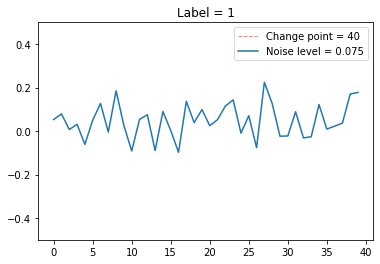

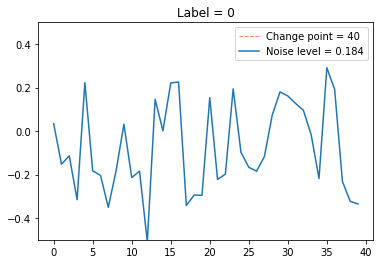

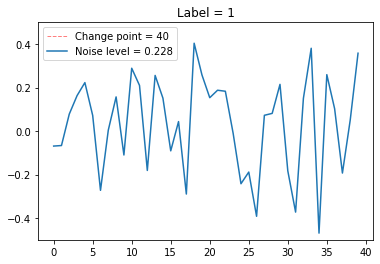

In [2]:
# data generation
device = 'cuda'

def generate_ns_batch(batch_size=20, seq_len=40, lower=0.1, upper=0.1, 
                      margin=0.1, min_change_point=15, max_change_point=25):
    """
    Generates a batch of data described as follows:
    Each sequence is either of class 1 or 0 with just a single input sequence.
    Up until time T all elements of a sequence are 0 + K + noise, where K = + 0.2 for 
    class 1 and - 0.2 for class 0. 
    Then after the T'th element of the sequence, all vaules are just 0 + noise (uninformative).
    The amount of noise and value of T determine how challenging a sequnece is. 
    
    Args:
        batch size (int): size of batch (must be even).
        seq_len (int): length of individual seqences.
        lower (float): lower bound for uniform distribution on the value of the stadard deviation
            of the gaussian noise for a given sequence.
        upper (float): upper bound for uniform distribution on the value of the stadard deviation
            of the gaussian noise for a given sequence.
        margin (float): the value of K in the above description.
        min_change_point (int): T is uniformly distributed ~ (min_change_point, max_change_point).
        max_change_point (int): T is uniformly distributed ~ (min_change_point, max_change_point).
        
    Returns:
        x_vals (Torch Tensor): Tensor of data of shape (batch_size, seq_len).
        y_vals (Torch Tensor): Corresponding labels of size (batch_size).
        T (Torch Tensor): Tensor of values of T for each sequence in the batch of size (batch_size).
            These are the indexes of the first element in the seq that contain no signal (i.e the
            optimal idx for spiking after).
        std_vec (Torch Tensor): Tensor of values of the the standard deviation of the noise for 
            each sequence in the batch of size (batch_size).
    
    """
    # generate labels
    y_vals = torch.tensor([1.,0.], device=device).repeat(int(batch_size/2))
    # make tensor of indexes for t
    T = torch.randint(low=min_change_point, high=max_change_point, size=(batch_size,), 
                      device=device)
    repeats = torch.empty(2*batch_size, dtype=torch.long, device=device)
    repeats[::2] = T
    repeats[1::2] = seq_len - T
    # make a 2d tensor based on these indexes
    vals = torch.tensor([1,0], device=device).tile(batch_size)
    data = torch.repeat_interleave(vals, repeats).reshape(batch_size, seq_len)
    # convert 1's to margin or -margin based on class
    margin_vec = torch.tensor([[margin, -margin]], device=device).tile(int(batch_size/2))
    data = data * margin_vec.T
    # finally add iid gaussian noise to all elements
    normal_mat = torch.randn((batch_size, seq_len), device=device)
    std_vec = (lower - upper) * torch.rand((batch_size,1), device=device) + upper
    noise = std_vec * normal_mat
    x_vals = data + noise
    # randomly shuffle the data 
    idxs = torch.randperm(batch_size)
    return x_vals[idxs], y_vals[idxs], T[idxs], std_vec[idxs]

X, y, T, std_vec = generate_ns_batch(min_change_point=40, max_change_point=41, 
                                     seq_len=40, lower=0.05, upper=0.25, margin=0.05)

# plot a few examples
for i in range(3):
    plt.title(f'Label = {int(y[i].item())}')
    plt.plot(X[i].cpu().numpy())
    legend_elements = [Line2D([0], [0], color='r', linestyle='--', lw=1, alpha = 0.5,
                              label=f'Change point = {T[i].item()}'),
                   Line2D([0], [0], color='#1f77b4', label=f'Noise level = {std_vec[i].item():.3f}')]
    plt.legend(handles=legend_elements)
    plt.ylim(-0.5, 0.5)
    plt.show()

### Define a simple LSTM

In [3]:

class LSTM(nn.Module):
    def __init__(self, input_size, output_size, nhid, f_bias=True):
        super(LSTM, self).__init__()
        self.nhid = nhid
        self.lstm = nn.LSTM(input_size, nhid, batch_first=True)
        self.linear = nn.Linear(nhid, output_size)

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        h0 = torch.zeros(1, inputs.size(0), self.nhid).to(device) 
        c0 = torch.zeros(1, inputs.size(0), self.nhid).to(device)
        y1, _ = self.lstm(inputs, (h0, c0))  # input should have dimension (B, S, I)
        o = self.linear(y1)
        return o


### And define some helper functions

In [4]:
# gather predictions from the first "spike"
def gather_spiking_preds(spikes, out, last_idx=39):
      """
      Gather predictions based on first spike or final output if no spike
      occurs. 

      Args:
          spikes (torch tensor): Tensor of binary spikes.
          out (torch tensor): Tensor of all model predictions.
          y (torch tensor)
          last_idx (int): Index of the final element in the sequence.

      Returns:
          Torch tensor: Outputs at these spiking values.
          Int: Number of observations in which no spike occured.
      """
      first_spike_idx = torch.argmax(spikes, dim=1, keepdim=True)
      no_spike_count = torch.sum(first_spike_idx == 0).item()
      # replace no spike with last idx for prediction
      first_spike_idx[first_spike_idx == 0] = last_idx
      preds = torch.gather(out, 1, first_spike_idx)  
      preds = preds.squeeze(-1).squeeze(-1)
      return preds, no_spike_count



# calculate mean spike time for both classes
def calc_mean_spike_times(spikes, y):
    first_spike_idx = torch.argmax(spikes, dim=1).squeeze(-1)
    class_0_spikes = first_spike_idx[(first_spike_idx > 0) * (y == 0)]
    class_1_spikes = first_spike_idx[(first_spike_idx > 0) * (y == 1)]
    class_0_mean = class_0_spikes.sum()/class_0_spikes.size(0)
    class_1_mean = class_1_spikes.sum()/class_1_spikes.size(0)
    return class_0_mean.item(), class_1_mean.item()



### Now train the LSTM using our rank coded training method

In [5]:
model = LSTM(1, 1, 125)
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = torch.nn.BCELoss()
s = nn.Sigmoid()

NUM_TRAIN_EXAMPLES = 4*500000
BATCH_SIZE = 128
VALIDATION_SIZE = 2000
VALIDATION_FREQ = 50

spiking_acc_ls = []
class_0_spike_times_ls = []
class_1_spike_times_ls = []
num_batches = int(np.ceil(NUM_TRAIN_EXAMPLES/BATCH_SIZE))
seq_lens = torch.repeat_interleave(torch.tensor([39]), BATCH_SIZE).unsqueeze(-1).unsqueeze(-1).to(device)
print('################## TRAINING ##################')
print('Training {} examples in batches of size {}'.format(NUM_TRAIN_EXAMPLES, BATCH_SIZE))
print(f'resulting in {num_batches} batches')
print('##############################################\n')

time.sleep(0.2)
for i in tqdm(range(num_batches)):
    ######################## TRAIN A BATCH ########################
    # generate some training data 
    X, y, _, _ = generate_ns_batch(batch_size=BATCH_SIZE, min_change_point=40,
                                   max_change_point=41, seq_len=40, lower=0.05,
                                   upper=0.25, margin=0.05)
    X.unsqueeze_(-1)
    
    # learn through network
    model.train()
    optimiser.zero_grad()
    out = model(X)
    out = s(out)
    
    # grab indixes of first spikes
    with torch.no_grad():
        spikes = ((out < 0.05) * 1) + ((out > 0.95) * 1)
        first_spike_idx = torch.argmax(spikes, dim=1, keepdim=True)
        first_spike_idx[first_spike_idx == 0] = 39  # replace no spike with last idx
    
    # then set these first spikes as the predictions
    preds = torch.gather(out, 1, first_spike_idx) 
    preds = preds.squeeze(-1).squeeze(-1)
    
    # and backpropogate loss
    loss = criterion(preds, y)
    loss.backward()
    optimiser.step()
    
    ######################## VALIDATION SET ########################
    if i % VALIDATION_FREQ == 0:
      model.eval()
      with torch.no_grad():
          X, y, opt_idx, _ = generate_ns_batch(VALIDATION_SIZE, min_change_point=40,
                                               max_change_point=41, seq_len=40,
                                               lower=0.05, upper=0.25, margin=0.05)
          X.unsqueeze_(-1)
          out = model(X)
          out = s(out)
          
          # generate tensor of spikes
          spikes = ((out < 0.05) * 1) + ((out > 0.95) * 1)
          preds, _ = gather_spiking_preds(spikes, out)

          # evaluate spiking accuracy
          spiking_acc_val = (torch.sum(y == torch.round(preds))/y.size(0)).item()
          spiking_acc_ls.append(spiking_acc_val)

          # store mean spike times
          mean_spike_times = calc_mean_spike_times(spikes, y)
          class_0_spike_times_ls.append(mean_spike_times[0])
          class_1_spike_times_ls.append(mean_spike_times[1]) 

################## TRAINING ##################
Training 2000000 examples in batches of size 128
resulting in 15625 batches
##############################################



100%|██████████| 15625/15625 [01:00<00:00, 257.34it/s]


### Plot the training dynamics evaluated on independant validation data
Note that although accuracy peaks early in training, the time of the first spike continues to improve for a long time.

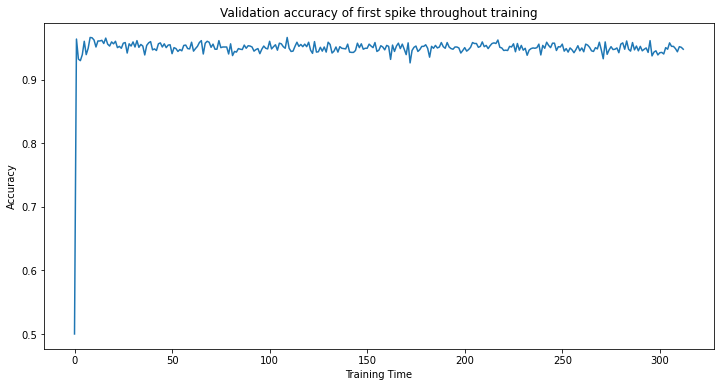

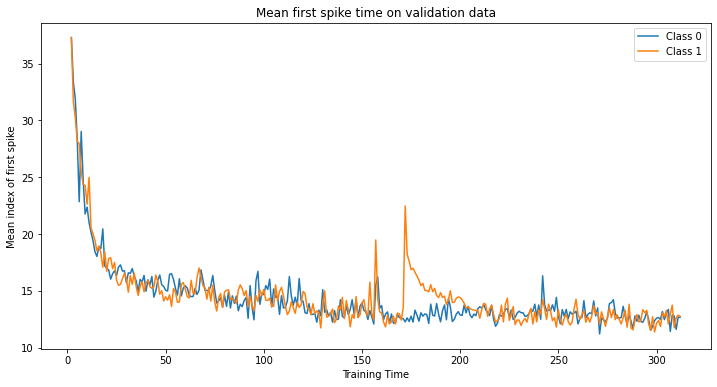

In [6]:
spiking_acc_ls
plt.figure(figsize=(12,6))
plt.title('Validation accuracy of first spike throughout training')
plt.plot(spiking_acc_ls)
plt.ylabel('Accuracy')
plt.xlabel('Training Time')
plt.show()

plt.figure(figsize=(12,6))
plt.title('Mean first spike time on validation data')
plt.plot(class_0_spike_times_ls, label='Class 0')
plt.plot(class_1_spike_times_ls, label='Class 1')
plt.ylabel('Mean index of first spike')
plt.xlabel('Training Time')
plt.legend()
plt.show()
